In [1]:
# Import Packages
import numpy as np
from torch.autograd import Variable
import torch
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

# Import local model files
from FBRN.myfunc import Physics
from FBRN.myfunc import MyMatmul
from FBRN.main import FBRestNet
from FBRN.model import MyModel

In [2]:
# Import the fourier method
from scripts.fouriermethod import Fourier_solver
from scripts.lowessmethod import LowessSolver

### Initialisation
The condition are as follows:
$a=1$ ,
$p=1$ ,
the constraint is $0 <x_i <1$ .

In [3]:
model = FBRestNet(
    model_id = 'model_000_',
    dataset_folder = '../Datasets/',
    model_folder = '../outputs/models/',
    opt_hist_folder = '../outputs/opt_hist/',
    results_folder = '../outputs/results/',
    experimentation=Physics(2000,50,1,1),
    nb_blocks=20,
    im_set="Set1",
    noise = 0.05,        
    constraint = 'cube',  
    train_size=400,
    val_size=200,
    batch_size=64,
    lr=3e-1, 
    nb_epochs=100,
    freq_val=1,
    loss_elt=True,
    save_signals=False,
    save_outputs=True,
    save_model=True,
    save_hist=True
    )


### Dataset

In [4]:
train_set, val_set = model.CreateDataSet()

# Train the model

In [5]:
pretrained = True
if pretrained:
    model.model.load_state_dict(torch.load('./../outputs/models/model_1_cube_weights.pt',map_location=torch.device('cpu')))
else:
    model.train(train_set,val_set)

# Naive reconstruction

In [6]:
data_set = next(iter(val_set))      # get the minibatch
y, x = data_set[0], data_set[1]            
x_true  = np.array(x)[0,0]
x_bias  = np.array(y)[0,0]

x_true_elt = model.physics.BasisChangeInv(x_true)

In [7]:
x_adjoint_elt = model.physics.BasisChangeInv( model.physics.ComputeAdjoint(model.physics.Compute(model.physics.BasisChangeInv(x_true))))
x_bias_elt = model.physics.BasisChangeInv(x_bias)
# plt.plot(x_bias_elt, label='noisy adjoint')
# plt.plot(x_adjoint_elt,label='true adjoint')
# plt.title('Adjoint signals')
# plt.legend()
# plt.show()

In [8]:
x_recover_clean = model.physics.inv.dot(model.physics.BasisChange(x_adjoint_elt) )
x_recover_noisy = model.physics.inv.dot(x_bias)

x_recover_clean_elt = model.physics.BasisChangeInv(x_recover_clean)
x_recover_noisy_elt = model.physics.BasisChangeInv(x_recover_noisy)

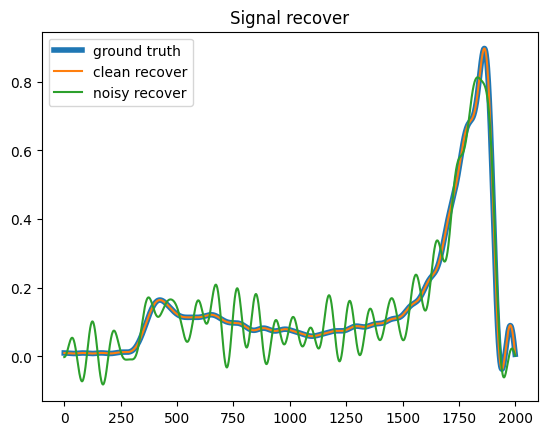

Relative error: 0.04782645393976946


In [9]:
plt.plot(x_true_elt, label='ground truth', linewidth=4)
plt.plot(x_recover_clean_elt, label='clean recover')
plt.plot(x_recover_noisy_elt,label='noisy recover')
plt.title('Signal recover')
plt.legend()
plt.show()

print('Relative error: {}'.format(np.sum((x_true_elt-x_recover_noisy_elt)**2)/np.sum(x_true_elt**2)))

# Tikhonov regularisation

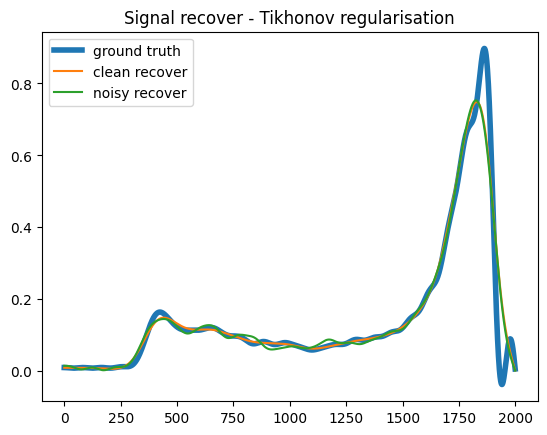

Relative error: 0.035352520675328


In [10]:
treshold = 1e-7
eig_vals = model.physics.eigw.copy()
tikho_inv = np.diag(eig_vals /(eig_vals**2 + treshold))

x_tikho_clean = tikho_inv.dot(model.physics.BasisChange(x_adjoint_elt) )
x_tikho_noisy = tikho_inv.dot(x_bias)

x_tikho_clean_elt = model.physics.BasisChangeInv(x_tikho_clean)
x_tikho_noisy_elt = model.physics.BasisChangeInv(x_tikho_noisy)


plt.plot(x_true_elt, label='ground truth', linewidth=4)
plt.plot(x_tikho_clean_elt, label='clean recover')
plt.plot(x_tikho_noisy_elt,label='noisy recover')
plt.title('Signal recover - Tikhonov regularisation')
plt.legend()
plt.show()

print('Relative error: {}'.format(np.sum((x_true_elt-x_tikho_noisy_elt)**2)/np.sum(x_true_elt**2)))

# Model reconstruction

In [11]:
loss, signals = model.test(val_set,plot_opt=False)

In [12]:
model_predictions_elt = np.load(model.results_folder+model.model_id+'predictions.npy')

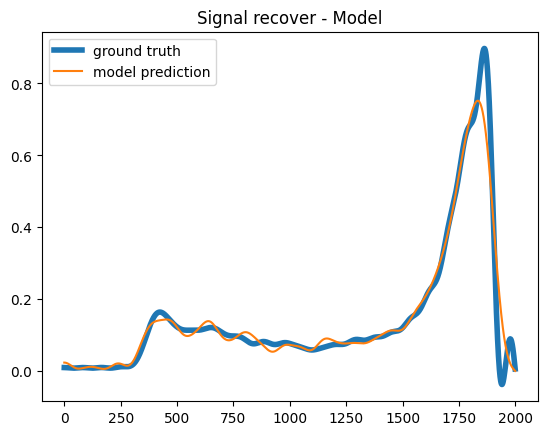

Relative error: 0.028554456501519748


In [13]:
plt.plot(x_true_elt, label='ground truth', linewidth=4)
plt.plot(model_predictions_elt[0,0], label='model prediction')
plt.title('Signal recover - Model')
plt.legend()
plt.show()

print('Relative error: {}'.format(np.sum((x_true_elt-model_predictions_elt[0,0])**2)/np.sum(x_true_elt**2)))

# Filter the recovered signal: Fourier method

In [14]:
f_cut = 15
filter = np.zeros((50,50))
np.fill_diagonal(filter[:f_cut,:f_cut], 1)


In [15]:
x_recover_filtered = filter.dot(x_recover_noisy)
x_recover_filtered_elt = model.physics.BasisChangeInv(x_recover_filtered)


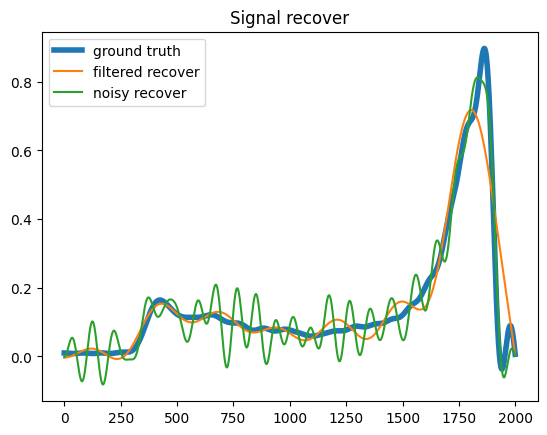

Relative error: 0.0692444126605538


In [16]:
plt.plot(x_true_elt, label='ground truth', linewidth=4)
plt.plot(x_recover_filtered_elt, label='filtered recover')
plt.plot(x_recover_noisy_elt,label='noisy recover')
plt.title('Signal recover')
plt.legend()
plt.show()

print('Relative error: {}'.format(np.sum((x_true_elt-x_recover_filtered_elt)**2)/np.sum(x_true_elt**2)))

## Quick test

In [17]:
f_filter = Fourier_solver(model.physics.nx,model.physics.m,model.physics.a,model.physics.p)

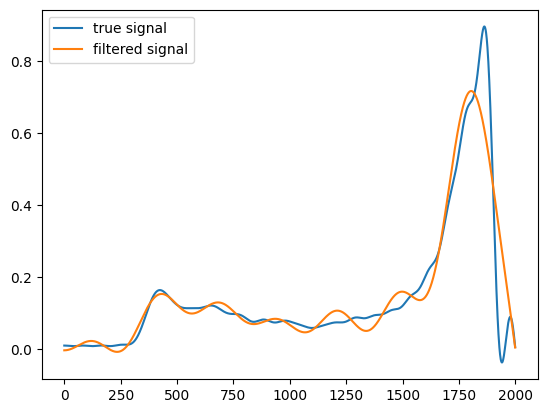

Example error: 0.0692444126605538
Average error: 0.02520766060809571


In [18]:
err, err_list = f_filter.Fourier_filter(val_set,15/50, display=True, idx=0)
print('Example error: {}'.format(err_list[0]))
print('Average error: {}'.format(err))

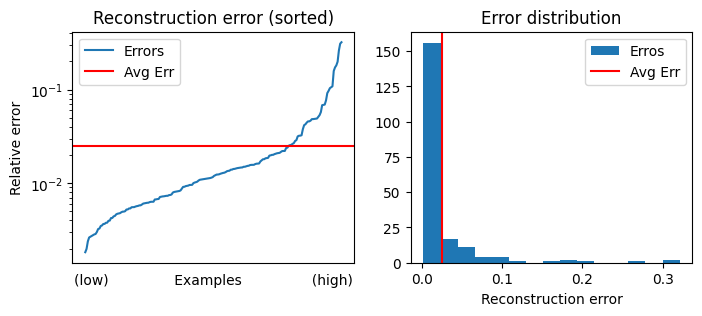

In [19]:
fig, ax = plt.subplots(1,2,figsize=(8,3))
ax[0].plot(np.sort(np.array(err_list)), label='Errors')
ax[0].set_yscale('log')
ax[0].axhline(y = err, color = 'r', label = 'Avg Err')
ax[0].set_title('Reconstruction error (sorted)')
ax[0].set_ylabel('Relative error')
ax[0].set_xlabel('(low)               Examples                (high)')
ax[0].legend()
ax[0].set_xticks([])

ax[1].hist(np.array(err_list), 15, label='Erros')
ax[1].axvline(x = err, color = 'r', label = 'Avg Err')
ax[1].legend()
ax[1].set_title('Error distribution')
ax[1].set_xlabel('Reconstruction error')
plt.show()

# LOWESS filter

In [20]:
l_filter = LowessSolver(model.physics.nx,model.physics.m,model.physics.a,model.physics.p)

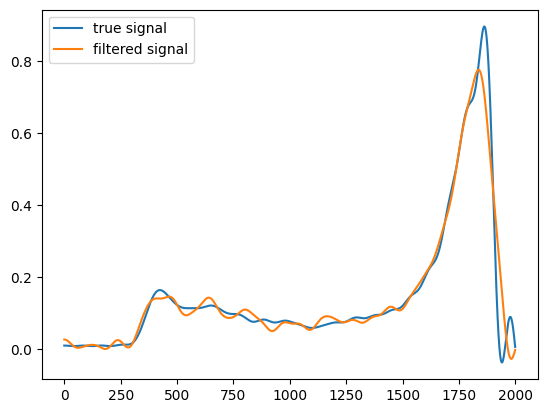

Example error: 0.03190147285777688
Average error: 0.021494806379053412


In [27]:
err_low, err_low_list = l_filter.Lowess_filter(val_set,frac=150/2000,it=1,delta=10, project=True, display=True, idx=0)
print('Example error: {}'.format(err_low_list[0]))
print('Average error: {}'.format(err_low))